# Goal
* Choose a genre as a test case

* Develop a method or model for predicting if a given film is in the test genre based on its Netflix description

* Evaluate accuracy of the top model and decide if it is high enough to proceed to the next step of creating a pipeline to acquire, prepare, create and evaluate a model that predicts True/False for each genre in the dataset for each 

In [1]:
# Imports

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

import sklearn.preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

import wrangle as w
import explore as e
import model as m

# Wrangle

* Data acquired from [Kaggle](https://www.kaggle.com/datasets/victorsoeiro/netflix-tv-shows-and-movies?select=titles.csv)

* Each row in the data represents a show appearing on Netflix at the time data was collected
* Columns were restricted to description and genre
* The following modifications were made when cleaning the text in description
     * Converted to lowercase
     * Special characters removed
     * Remove non-ascii characters
     * Lemmatize tokens
     * Remove stop words using standard list plus two letter words
* Boolean columns for each genre appearing in the genres column were added 
     * These columns indicate if the show belonged to that genre
* Dataset contains 5791 rows after being prepared 
* full dataset was split into train, validate and test sets 
     * Train set contains 3242 rows
     * Validate set contains 1390 rows
     * Test set contains 1159 rows

In [2]:
#acquire and prepare data
df = w.get_show_data()

# split data into train, validate and prep
train, validate, test = w.split_my_data(df)

# print number ow rows in train
print(f"Train set contains {train.shape[0]} rows of data")
print(f"Validate set contains {validate.shape[0]} rows of data")
print(f"Test set contains {test.shape[0]} rows of data")

Train set contains 3242 rows of data
Validate set contains 1390 rows of data
Test set contains 1159 rows of data


# Explore

## 1. Choose a genre as a test case using the following criteria:
   * Genre has large representation in the data
   * Genre has a large number of unique words
   * Genre has a high number of unique words appearing in each description
   * Genre is relatively easy for a human to intuit 

## 2. Explore the chosen genre:
   * How much of the data is represented by the chosen genre?
   * What is the distribution of word and document frequency for the chosen genre?
   * What words have the highest and lowest word and document frequency?
   * Is it possible to predict the chosen genre using unique words?

In [3]:
# get set of genres
gen_set = e.get_gens(train)

# get relative word frequency list and list of only the numbers
word_freq = e.get_word_freq(train)
word_counts = e.get_counts(word_freq)

# get relative document frequency list and list of only the numbers
doc_freq = e.get_doc_freq(train)
doc_counts = e.get_counts(doc_freq)

## 1. Choose a Test Case 

### What is the distribution of genres in the train data?

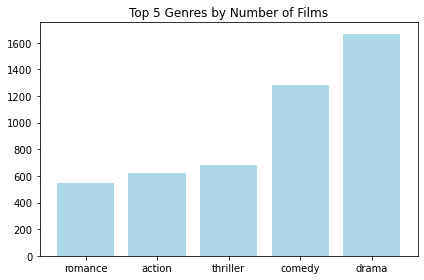

In [4]:
# display distribution of genres
shows_per_gen = e.get_shows_per_gen(train, gen_set)
e.get_bar(shows_per_gen, "Top 5 Genres by Number of Films")

* Comedy and Drama are by far the most highly represented genres in the training data.

### How many different unique words appear in each genre? 

* Unique Words are words that appear in the descriptions of films in a given genre and do not appear in descriptions of films that are not in that genre

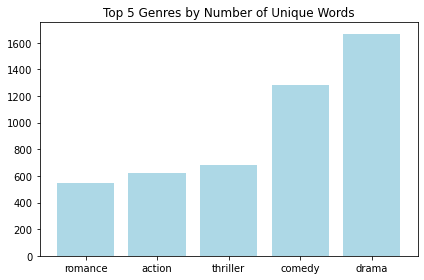

In [5]:
# display number of different unique words in each genre
unique_words_per_gen = e.get_unique_words_per_gen(train, gen_set)
e.get_bar(shows_per_gen, "Top 5 Genres by Number of Unique Words")

* Comedy and Drama contain by far the largest number of differint unique words

### What is the average number of times unique words appear in descriptions of each genre?

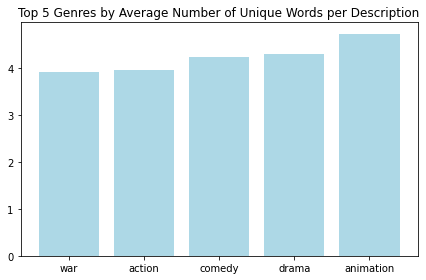

In [6]:
# get frequency of unique words pre genre
unique_word_appearance_per_genre = e.get_unique_word_appearance_per_genre(train, gen_set)
e.get_bar(unique_word_appearance_per_genre, "Top 5 Genres by Average Number of Unique Words per Description")

* Not a great deal of variance in unique word appearance frequency
* Animation has the highest appearance frequency
* Comedy and Drama are close behind

## Test Case Conclusion

* Comedy and Drama have high values in all of the testable criteria
   * Representation in the data
   * Number of unique words
   * High number of unique words appearing in each description
* Either genre would make a reasonable choice
* The last criteria is how easily the genre would be to intuit for a human
    * Comedy seems to me the earlier of the two genres for a human to intuit 

**For these reasons I am choosing comedy as the test case for this project**

## 2) Explore the Comedy Genre

* What percent of the data is classified as a Comedy?
* What does the relative occurrence of words in comedy or non-comedy films tell us?

## How much of the data is Comedy?

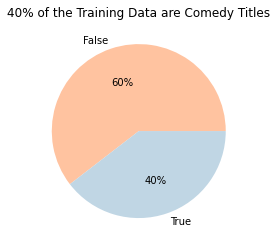

In [7]:
e.omni_pie(train.comedy, "40% of the Training Data are Comedy Titles")

## What does the relative occurrence of words in comedy or non-comedy films tell us?

I will look at two separate measures:
* **Relative Word Frequency**
    * Calculated by adding the number of times a given word appears in comedy film descriptions and subtracting the number of times that word appears in non-comedy film descriptions
* **Relative Document Frequency**
    * Calculated by adding the number of comedy descriptions a given word appears in and subtracting the number of non-comedy films the word appears in

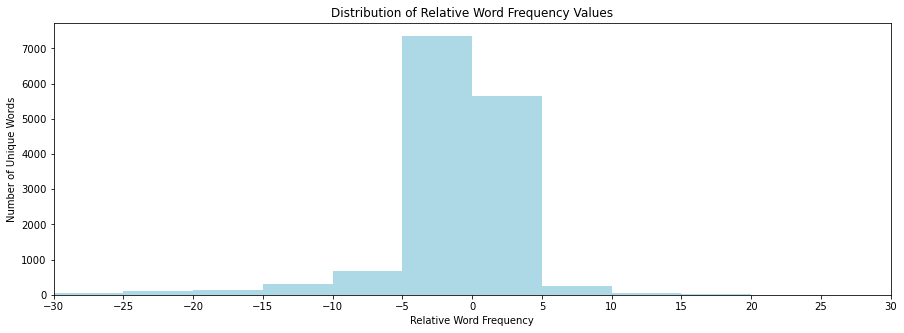

In [8]:
e.get_hist(word_counts,"Distribution of Relative Word Frequency Values","Relative Word Frequency")

* Observations:
    * Majority of the data is between -5 and positive 5
    * There is a negative skew to the data likely due to a 60/40 imbalance in the data
    
* Takeaways:
    * There are a lot of numbers at values close to zero. This shows that there are a large number of words that are not strongly indicative of comedy or non-comedy. Removing these "low value" numbers may reduce noise in the model
    * Because the data is so focused around the 5 to - 5 mark I will concentrate on that range to remove potential noise
    * Because of the negative skew in the data words that have a high negative value may have it due the data imbalance meaning they are not true indicators of non_comedy films
    * Because the skew favors negative values it is more likely that words with positive values are true indicators of comedy films 
    

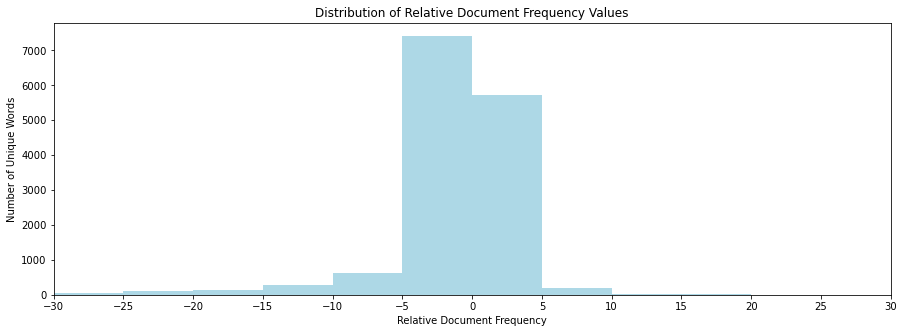

In [9]:
e.get_hist(doc_counts, "Distribution of Relative Document Frequency Values","Relative Document Frequency")

* Observations:
    * Majority of the data is between -5 and positive 5
    * There is a negative skew to the data likely due to a 60/40 imbalance in the data
    
* Takeaways:
    * There are a lot of numbers at values close to zero. This shows that there are a large number of words that are not strongly indicative of comedy or non-comedy. Removing these "low value" numbers may reduce noise in the model
     * Because the data is so focused around the 5 to - 5 mark I will concentrate on that range to remove potential noise
    * Because of the negative skew in the data, words that have a high negative value may have it due the data imbalance meaning they are not true indicators of non_comedy films
    * Because the skew favors negative values it is more likely that words with positive values are true indicators of comedy films 

## What do the most extreme 15 most extreme positive and negative frequency values tell us?

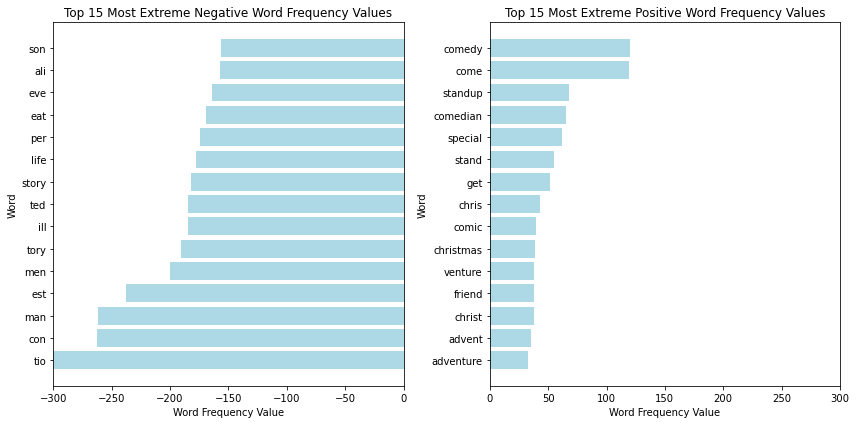

In [10]:
e.display_ext_values(dict(word_freq[:15]),"Top 15 Most Extreme Negative Word Frequency Values", dict(word_freq[-15:]), "Top 15 Most Extreme Positive Word Frequency Values","Word Frequency Value", "Word", 300)

* Observations
    * Extreme positive values are much closer to zero than their negative counterparts and include words that are intuitively indicative of comedy such as comedy, comedian, and standup
    * Extreme negative values are much farther from zero and do not include words that are intuitively indicative of non-comedy films
* Takeaways
    * This gives further evidence that low value words may be common words that appear more frequently in non-comedy films due to data imbalance
    * This also gives further evidence that high value words are likely to be strong indicators of comedy films due to surviving the imbalance and being intuitively indicative of comedy films 

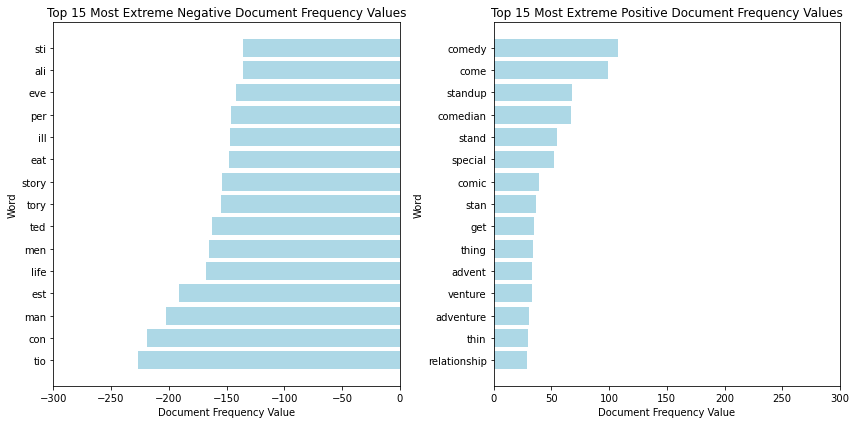

In [11]:
e.display_ext_values(dict(doc_freq[:15]), "Top 15 Most Extreme Negative Document Frequency Values", dict(doc_freq[-15:]), "Top 15 Most Extreme Positive Document Frequency Values", "Document Frequency Value", "Word", 300)

* Observations
    * Exteme positive values are much closer to zero than their negative counterparts and include words that are intuitively indicative of comedy such as comedy, comedian, and standup
    * Extreme negative values are much farther from zero and do not include words that are intuitively indicative of non-comedy films
* Takeaways
    * This gives evidence that low value words may be common words that appear more frequently in non-comedy films due to the data imbalance
    * This also gives further evidence that high value words are likely to be strong indicators of comedy films due to surviving the imbalance and being intuitivly indicative of comedy films 

## Exploration Summary

* Data Split
    * Training data has a 60/40 split of comedy and non-comedy data
* Relative Frequency Distribution
    * Relative frequency metrics both showed that values normalize around values close to zero. Values close to or at zero are likely not indicative of whether a film is comedy or non-comedy. Removing these values will likely reduce noise in the model
    * Both metrics indicate a negative skew likely do to an imbalance in the data
    * Word frequency seems to be more skewed than Document frequency
* Extreme Value Words
    * Extreme positive values are much closer to zero than their negative counterparts and include words that are intuitively indicative of comedy such as comedy, comedian, and standup
    * Extreme negative values are much farther from zero and do not include words that are intuitively indicative of non-comedy films
    * This gives evidence that low value words may be common words that appear more frequently in non-comedy films due to the data imbalance
    * This also gives evidence that high value words are likely to be strong indicators of comedy films due to surviving the imbalance and being intuitively indicative of comedy films 

# Predictions Using Unique Words

On average 4 or more unique words will appear in the description of each comedy film. Based on this I will test whether I can predict if a film is a comedy or non-comedy by using the presence or absence of unique words. I will use the following method:

* Unique words for comedy and non-comedy will be identified using train data and used to predict validate data
* Values will be assigned to each prediction according the presence/number of unique comedy and non-comedy words
* Prediction methods will be evaluated in terms of overall accuracy and override accuracy
    * Overall Accuracy = total correct predictions / total attempted predictions
        * Non-Boolean results will count as missed predictions
    * Override Accuracy = total correct True or False predictions / Total True or False predictions
        * Non-Boolean results will not be considered
* I will use two methods of prediction:
    * Presence of unique words
        * Has unique words for comedy and no unique words for non-comedy = True
        * Has unique words for non-comedy and no unique words for comedy = False
        * Has both = Has Both 
        * Has neither = Contains Neither
    * Majority of unique words
        * Has more comedy unique words than non-comedy unique words = True
        * Has more non-comedy unique words than comedy unique words = False
        * Has an equal number of comedy and non-comedy unique words = Equal Count
        * Has neither = Has Neither
* Due to the 60/40 split in the data I am setting the baseline accuracy of 60% 

If the overall accuracy of this prediction method is high enough it could be used as an alternative to traditional modeling. If override accuracy beats a given model's overall accuracy it could be used in conjunction with traditional modeling to override model results where the prediction method produces a boolean result.


In [12]:
# get set of words occuring in comedy and non-comedy descriptions
com_train = e.get_description_set_of_words(train[train.comedy == True])
non_train = e.get_description_set_of_words(train[train.comedy == False])

# get set of words appearing in only comedy or non-comedy descriptions
com_unique_train = com_train.difference(non_train)
non_unique_train = non_train.difference(com_train)

# get train and validate dataframes with only description and comedy columns
train_evaluation_df = train[['description','comedy']]
validate_evaluation_df = validate[['description','comedy']]

# Sanity Test - Predicting Train Using Presence of Unique Words 

In [13]:
m.get_predictions_presence(train_evaluation_df, com_unique_train, non_unique_train)

Prediction Value Counts
-----------------------
False               1837
True                1168
contains niether     237
Name: prediction, dtype: int64

Evaluation Results
-----------------------
True     3005
False     237
Name: evaluation, dtype: int64

Overall Accuracy
-----------------------
93.0

Override Accuracy
-----------------------
100.0


* Sanity Test performed as expected 
* This method produced the same number of incorrect predictions and contains neither results giving evidence that
    * All of the train data cases that contain unique words for either comedy or non-comedy correctly identified 
    * Those that did not were classified as contains neither 

# Predicting Validate Using Presence of Unique Words 

In [14]:
m.get_predictions_presence(validate_evaluation_df, com_unique_train, non_unique_train)

Prediction Value Counts
-----------------------
contains both       512
False               486
contains niether    213
True                179
Name: prediction, dtype: int64

Evaluation Results
-----------------------
False    941
True     449
Name: evaluation, dtype: int64

Overall Accuracy
-----------------------
32.0

Override Accuracy
-----------------------
68.0


* Overall Accuracy is very poor due to a large number of films that either contained unique words from both comedy and non-comedy or contained no unique words
* Even when considering only True/False predictions Override accuracy is only 8% above baseline
* I do not recommend using this method of prediction

# Predicting Validate Using Number of Unique Words 

In [15]:
m.get_predictions_number(validate_evaluation_df, com_unique_train, non_unique_train)

Prediction Value Counts
-----------------------
False          739
equal count    379
True           272
Name: prediction, dtype: int64

Evaluation Results
-----------------------
False    708
True     682
Name: evaluation, dtype: int64

Overall Accuracy
-----------------------
49.0

Override Accuracy
-----------------------
67.0


* Overall Accuracy improves, but is still below baseline. Increase is likely due to increasing the number of True/False predictions it could make.
    * 512 predictions were lost in the previous method because they contained both types of unique words
    * 213 predictions were lost in the previous method because they contained no unique words
    * 725 predictions were lost all together the
    * 317 predictions were lost in the current method due to having an equal number of comedy and non-comedy unique words
    * 408 additional predictions were made using this method
* Override Accuracy is slightly worse using this method at 7% above baseline


## Predicting Using Unique Words Conclusion

* Baseline 60% 
* Predicting on Presence of Unique Words 
    * Overall Accuracy of 32% is far below baseline
    * Override Accuracy of 68% is slightly better than baseline
        * If a given model's accuracy is less I would consider using this method as an override if the overridden model is less than 68% accurate.
* Predicting on Number of Unique Words
    * Overall Accuracy of 49% is far below baseline
    * Override Accuracy of 67% is worse than predicting on presence alone
        * If a given model's accuracy is less I would consider using this method as an override if the overridden model is less than 67% accurate.
* Takeaways
    * At the moment I do not recommend using either method to make predictions
        * Overall accuracy is below baseline on both
        * Using it as an override is only useful if the model being overridden is predicting less accurately than the method, and I don't think a model that predicts less accurately than either of these methods should be moved forward with
    * Adjustments may be possible
        * Perhaps predicting based on totaling the relative frequency of each word in the description would yield better results
            * I would need to adjust how relative frequency is measured to avoid skewing the results due to data imbalance
                * perhaps using percentage of appearances instead of number of appearances.


# Modeling

* I will examine two types of vectorization arrays
   * Count - Each word is assigned a number value for each film counting the number of times it appears in the description
   * TF-IDF - Each word is assigned a number value for each film in a calculation which lowers the value based on the number of descriptions in the data it appears in and raises the value based on the number of times the word appears in the description of the film
* I will examine feature engineering using relative frequency
    * I will examine two different measures
        * Relative frequency by total number of times the word appears in all documents (film descriptions)
        * Relative frequency by number of documents (film descriptions) that contain the word
    * I will choose a threshold for removal
    * Words with a relative frequency between negative threshold and threshold will be removed 
    * Results of predictions made using different machine learning models will be compared before removing any columns and after removing columns at different thresholds
        * Thresholds used will be 0, 5, 20, 50, and 100
* I will examine results of different machine learning models
    * Decision Tree
    * Random Forest
    * K Nearest Neighbors
    * Logistic Regression
* Models will be evaluated in terms of overall accuracy 
* Because of the 60/40 split in the data baseline will be set at 60%

## Note !

* Model evaluations take a long time to run! For this reason the code that runs the evaluations in the notebook has been commented out and replaced with Markdown table displaying the results and formatted for ease of comparison. Feel free to uncomment that code in your cloned notebook to run the model results for yourself.

In [16]:
# seperate train, validate and test data into X (description) and y (comedy)
train_X = train[['description']].reset_index(drop=True)
train_y = train[['comedy']].reset_index(drop=True)

validate_X = validate[['description']].reset_index(drop=True)
validate_y = validate[['comedy']].reset_index(drop=True)

test_X = test[['description']].reset_index(drop=True)
test_y = test[['comedy']].reset_index(drop=True)

## Count Analysis - Full Vectorization Array

In [17]:
# vectorize discriptions using counts
train_counts, validate_counts, test_counts = m.get_vectorized_data(train_X, validate_X, test_X, CountVectorizer())

In [18]:
print("| Threshold |        Model        | Accuracy On Trian | Accuracy on Validate |")
print(" ----------------------------------------------------------------------------")
print("|{0:^11}|{1:^21}|{2:^19}|{3:^22}|".format("one", "Logistic Regression", 78.97, 56.89 ))

| Threshold |        Model        | Accuracy On Trian | Accuracy on Validate |
 ----------------------------------------------------------------------------
|    one    | Logistic Regression |       78.97       |        56.89         |


In [52]:
def evaluate_model(train_X, train_y, validate_X, validate_y, clf, label, threshold):
    ''' Evaluates Model on train and validate and prints line of evaluation chart'''
    
    obj = clf.fit(train_X, train_y)

    train_score = obj.score(train_X, train_y)
    train_score = str(round(train_score * 100, 2)) + "%"

    validate_score = obj.score(validate_X, validate_y)
    validate_score = str(round(validate_score * 100, 2)) + "%"

    print("| {0:^9} | {1:^21}|{2:^19}|{3:^22}|".format("N/A", label, train_score, validate_score))
    
    
def remove_low_freq(df_X, freq_dict, threshold):
    ''' Restricts columns in vectorized df to those that have an relative frequency grater than threshold numbers from zero'''
    
    df_cols = list(df_X.columns)

    new_cols = [col for col in df_cols if abs(freq_dict[col]) > threshold]
 
    return df_X[new_cols]


def get_acc_table(train_X, train_y, validate_X, validate_y, freq_dict):
    ''' take in train data split into X and y, Validate data split into X and y
        print table of accuracy scores for train and validate data when run on each classifier in the list'''

    # List of classifiers and labels
    clf_lst = [DecisionTreeClassifier(random_state = 411),
               RandomForestClassifier(random_state = 411),
               KNeighborsClassifier(),
               LogisticRegression(random_state = 411)]
    
    label_lst = ["Decision Tree ",
                 "Random Forest ",
                 "K Neighbors ",
                 "Logistic Regression"]
    
    index = 0

    # print beginning of table
    print()
    print(" _____________________________________________________________________________ ")
    print("| Threshold |        Model         | Accuracy On Trian | Accuracy on Validate |")
    print(" ----------------------------------------------------------------------------- ")

    # Itterate through classifiers and evaluate each on train and validate 
    # Then print results in a table 
    for clf in clf_lst:

        # Evaluate model with full vectorized data
        label = label_lst[index]
        
        threshold = "N/A"
        
        # Build evaluate and print results of model in table
        evaluate_model(train_X, train_y, validate_X, validate_y, clf, label, threshold)

        # Itterate through thresholds 
        for thresh in [0, 1, 2, 3, 4, 5]:
            
            threshold = thresh
            
            train_X = remove_low_freq(train_X, freq_dict, threshold)
            validate_X = remove_low_freq(validate_X, freq_dict, threshold)
            
            # Build evaluate and print results of model in table
            evaluate_model(train_X, train_y, validate_X, validate_y, label, threshold)
            
    index += 1  

In [51]:
# runs model evaluations, uncomment the following to run the model evaluations for yourself 

get_acc_table(train_counts, train_y, validate_counts, validate_y, dict(word_freq))


 _____________________________________________________________________________ 
| Threshold |        Model         | Accuracy On Trian | Accuracy on Validate |
 ----------------------------------------------------------------------------- 
|    N/A    |    Decision Tree     |      99.97%       |        63.88%        |


TypeError: evaluate_model() missing 1 required positional argument: 'threshold'

| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | Decision Tree       | 99.97%            | 63.88%               |
| Nothing Removed | Random Forest       | 99.97%            | 70.07%               |
| Nothing Removed | K Neighbors         | 62.86%            | 60.50%               |
| Nothing Removed | Logistic Regression | 99.78%            | **71.80%**           |

* Highest performing model on validate is logistic regression with an accuracy of 71.80%
* This beats baseline by almost 12%

## Count Analysis - Drop low Relative Frequency - Raw Counts

In [21]:
for item in [0, 1, 2, 3, 4, 5]:
    
    m.get_acc_after_freq_drop(train_counts, train_y, validate_counts, validate_y, word_freq, item)


Drop threshold is 0
Accuracy Scores
---------------
Decision Tree  Train: 99.97% Validate: 66.69%
Random Forest  Train: 99.97% Validate: 70.22%
K Neighbors  Train: 63.13999999999999% Validate: 60.22%
Logistic Regression Train: 99.6% Validate: 71.94%

Drop threshold is 1
Accuracy Scores
---------------
Decision Tree  Train: 99.97% Validate: 64.89%
Random Forest  Train: 99.97% Validate: 70.07%
K Neighbors  Train: 66.78% Validate: 60.72%
Logistic Regression Train: 97.69% Validate: 72.00999999999999%

Drop threshold is 2
Accuracy Scores
---------------
Decision Tree  Train: 99.97% Validate: 64.1%
Random Forest  Train: 99.97% Validate: 69.57%
K Neighbors  Train: 74.24% Validate: 61.01%
Logistic Regression Train: 95.74000000000001% Validate: 71.28999999999999%

Drop threshold is 3
Accuracy Scores
---------------
Decision Tree  Train: 99.97% Validate: 62.949999999999996%
Random Forest  Train: 99.97% Validate: 69.78%
K Neighbors  Train: 81.06% Validate: 56.55%
Logistic Regression Train: 93.28

| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | Decision Tree       | 99.97%            | 64.82%               |
|   0             | Decision Tree       | 99.97%            | **65.97%**           |
|   1             | Decision Tree       | 99.94%            | 63.88%               |
|   2             | Decision Tree       | 98.12%            | 61.80%               |
|   3             | Decision Tree       | 80.97%            | 63.24%               |
|   4             | Decision Tree       | 67.40%            | 62.52%               |
|   5             | Decision Tree       | 67.40%            | 62.52%               |

| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | 
|   0             | Decision Tree  Train: 99.97% Validate: 66.69%
|   1             |
|   2             | 
|   3             |
|   4             |
|   5             |

| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | 
|   0             | Random Forest  Train: 99.97% Validate: 70.22%
|   1             |
|   2             | 
|   3             |
|   4             |
|   5             |


| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | 
|   0             | 
|   1             |
|   2             | 
|   3             |
|   4             |
|   5             |





Drop threshold is 0
Accuracy Scores
---------------


K Neighbors  Train: 63.13999999999999% Validate: 60.22%
Logistic Regression Train: 99.6% Validate: 71.94%

Drop threshold is 1
Accuracy Scores
---------------
Decision Tree  Train: 99.97% Validate: 64.89%
Random Forest  Train: 99.97% Validate: 70.07%
K Neighbors  Train: 66.78% Validate: 60.72%
Logistic Regression Train: 97.69% Validate: 72.00999999999999%

Drop threshold is 2
Accuracy Scores
---------------
Decision Tree  Train: 99.97% Validate: 64.1%
Random Forest  Train: 99.97% Validate: 69.57%
K Neighbors  Train: 74.24% Validate: 61.01%
Logistic Regression Train: 95.74000000000001% Validate: 71.28999999999999%

Drop threshold is 3
Accuracy Scores
---------------
Decision Tree  Train: 99.97% Validate: 62.949999999999996%
Random Forest  Train: 99.97% Validate: 69.78%
K Neighbors  Train: 81.06% Validate: 56.55%
Logistic Regression Train: 93.28% Validate: 71.22%

Drop threshold is 4
Accuracy Scores
---------------
Decision Tree  Train: 99.97% Validate: 62.370000000000005%
Random Forest  Train: 99.97% Validate: 69.28%
K Neighbors  Train: 76.96% Validate: 51.15%
Logistic Regression Train: 90.47% Validate: 69.78%

Drop threshold is 5
Accuracy Scores
---------------
Decision Tree  Train: 99.94% Validate: 64.82%
Random Forest  Train: 99.94% Validate: 69.64%
K Neighbors  Train: 80.38% Validate: 58.63%
Logistic Regression Train: 88.99000000000001% Validate: 69.28%



* Observations
    * Dropping word columns based on relative frequency results in small positive impacts on most of the models usually between ~.1 and ~2% 
    * The best performing model was only slightly improved from 71.80% to 71.94%
* Takeaways
    * It appears that there are some gains to be has when dropping words with relative frequency values that are less close to zero
    * Such a small change in the leading model could reflect entropy in the data. It is unclear weather this change reflects an actual gain or statistical entropy
    * It is also unclear weather such a small gain would be worth the extra processing time

## Count Analysis - Drop low Relative Frequency - Document Counts

In [22]:
for item in [0, 1, 2, 3, 4, 5]:

    m.get_acc_after_freq_drop(train_counts, train_y, validate_counts, validate_y, doc_freq, item)


Drop threshold is 0
Accuracy Scores
---------------
Decision Tree  Train: 99.97% Validate: 66.33%
Random Forest  Train: 99.97% Validate: 70.28999999999999%
K Neighbors  Train: 63.39% Validate: 60.36%
Logistic Regression Train: 99.53999999999999% Validate: 71.37%

Drop threshold is 1
Accuracy Scores
---------------
Decision Tree  Train: 99.97% Validate: 65.47%
Random Forest  Train: 99.97% Validate: 69.78%
K Neighbors  Train: 67.27% Validate: 59.64%
Logistic Regression Train: 97.13000000000001% Validate: 71.65%

Drop threshold is 2
Accuracy Scores
---------------
Decision Tree  Train: 99.97% Validate: 65.11%
Random Forest  Train: 99.97% Validate: 68.99%
K Neighbors  Train: 74.24% Validate: 60.5%
Logistic Regression Train: 95.25% Validate: 71.50999999999999%

Drop threshold is 3
Accuracy Scores
---------------
Decision Tree  Train: 99.97% Validate: 64.68%
Random Forest  Train: 99.97% Validate: 70.36%
K Neighbors  Train: 79.92% Validate: 56.910000000000004%
Logistic Regression Train: 92.5

| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | Decision Tree       | 99.97%            | 64.82%               |
|   0             | Decision Tree       | 99.97%            | **65.90%**           |
|   5             | Decision Tree       | 99.94%            | 63.45%               |
|  20             | Decision Tree       | 97.90%            | 59.93%               |
|  50             | Decision Tree       | 77.64%            | 63.74%               |
| 100             | Decision Tree       | 66.38%            | 62.73%               |

| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | Random Forest       | 99.97%            | 69.86%               |
|   0             | Random Forest       | 99.97%            | **70.22%**           |
|   5             | Random Forest       | 99.94%            | 69.57%               |
|  20             | Random Forest       | 97.90%            | 65.18%               |
|  50             | Random Forest       | 77.64%            | 64.75%               |
| 100             | Random Forest       | 66.38%            | 62.52%               |

| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | K Neighbors         | 62.86%            | **60.50%**           |
| 0               | K Neighbors         | 63.39%            | 60.36%               |
| 5               | K Neighbors         | 81.0%             | 56.91%               |
| 20              | K Neighbors         | 75.94%            | 59.14%               |
| 50              | K Neighbors         | 67.30%            | 57.99%               |
| 100             | K Neighbors         | 60.18%            | 56.55%               |


| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | Logistic Regression | 99.78%            | **71.80%**           |
| 0               | Logistic Regression | 99.54%            | 71.37%               |
| 5               | Logistic Regression | 87.79%            | 70.29%               |
| 20              | Logistic Regression | 74.61%            | 68.56%               |
| 50              | Logistic Regression | 67.98%            | 66.62%               |
| 100             | Logistic Regression | 63.97%            | 63.02%               |

* Observations
    * There was marginal improvement in some scores as removing values at threshold 0
    * There was no improvement in the top performing model logistic regression at 71.80%
* Takeaways
    * It appears using document frequency to remove low value words yields only marginal results at best when applied to count vectorized data

## TF-IDF Analysis - Full Vectorization Array

In [23]:
train_tfidf, validate_tfidf, test_tfidf = m.get_vectorized_data(train_X, validate_X, test_X, TfidfVectorizer())

In [24]:
m.get_acc_table(train_tfidf, train_y, validate_tfidf, validate_y)

Accuracy Scores
---------------
Decision Tree  Train: 99.97% Validate: 61.150000000000006%
Random Forest  Train: 99.97% Validate: 70.43%
K Neighbors  Train: 80.35% Validate: 67.63%
Logistic Regression Train: 88.25% Validate: 70.43%


| Threshold       | Model               | Accuracy On Train | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | Decision Tree       | 99.97%            | 61.58%               |
| Nothing Removed | Random Forest       | 99.97%            | 70.00%               |
| Nothing Removed | K Neighbors         | 80.35%            | 67.63%               |
| Nothing Removed | Logistic Regression | 88.25%            | **70.43%**           |

* Observations
    * Top models on validate are Random Forest and Logistic Regression at ~70% accuracy
    * This is ~ 10% improvement on baseline but is ~1% worse than the counts vectorized data
* Takeaways 
    * It seems that count vectorized data is slightly better than TF-IDF vectorization before removing data

# Word

In [25]:
for item in [0, 1, 2, 3, 4, 5]:
    
    m.get_acc_after_freq_drop(train_tfidf, train_y, validate_tfidf, validate_y, word_freq, item)


Drop threshold is 0
Accuracy Scores
---------------
Decision Tree  Train: 99.97% Validate: 62.45%
Random Forest  Train: 99.97% Validate: 69.64%
K Neighbors  Train: 40.78% Validate: 40.0%
Logistic Regression Train: 87.51% Validate: 71.00999999999999%

Drop threshold is 1
Accuracy Scores
---------------
Decision Tree  Train: 99.97% Validate: 61.44%
Random Forest  Train: 99.97% Validate: 69.64%
K Neighbors  Train: 50.739999999999995% Validate: 43.53%
Logistic Regression Train: 83.59% Validate: 70.36%

Drop threshold is 2
Accuracy Scores
---------------
Decision Tree  Train: 99.97% Validate: 59.78%
Random Forest  Train: 99.97% Validate: 69.78%
K Neighbors  Train: 87.01% Validate: 51.370000000000005%
Logistic Regression Train: 81.92% Validate: 70.0%

Drop threshold is 3
Accuracy Scores
---------------
Decision Tree  Train: 99.97% Validate: 60.36%
Random Forest  Train: 99.97% Validate: 68.78%
K Neighbors  Train: 45.769999999999996% Validate: 41.65%
Logistic Regression Train: 79.979999999999

| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | Decision Tree       | 99.97%            | 61.58%               |
|   0             | Decision Tree       | 99.97%            | **62.30%**           |
|   5             | Decision Tree       | 99.97%            | 60.14%               |
|  20             | Decision Tree       | 99.23%            | 59.86%               |
|  50             | Decision Tree       | 92.69%            | 60.65%               |
| 100             | Decision Tree       | 82.54%            | 57.34%               |

| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | Random Forest       | 99.97%            | **70.00%**           |
|   0             | Random Forest       | 99.97%            | 69.93%               |
|   5             | Random Forest       | 99.97%            | 67.05%               |
|  20             | Random Forest       | 99.23%            | 64.75%               |
|  50             | Random Forest       | 92.69%            | 62.88%               |
| 100             | Random Forest       | 82.54%            | 58.85%               |

| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | K Neighbors         | 80.35%            | **67.63%**           |
| 0               | K Neighbors         | 40.78%            | 40.00%               |
| 5               | K Neighbors         | 84.15%            | 55.11%               |
| 20              | K Neighbors         | 75.85%            | 59.71%               |
| 50              | K Neighbors         | 72.92%            | 62.88%               |
| 100             | K Neighbors         | 67.77%            | 60.43%               |


| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | Logistic Regression | 88.25%            | 70.43%               |
| 0               | Logistic Regression | 87.51%            | **71.01%**           |
| 5               | Logistic Regression | 77.76%            | 69.50%               |
| 20              | Logistic Regression | 71.16%            | 68.35%               |
| 50              | Logistic Regression | 67.15%            | 66.55%               |
| 100             | Logistic Regression | 63.60%            | 63.02%               |

* Observations
    * There was marginal improvement in some scores by removing values at threshold 0
    * There was marginal improvement in the top performing model Logistic Regression ~.4%
    * Top model does not beat top "counts" model 71.80%
* Takeaways
    * It appears using relative word frequency to remove low value words yealds only marginal results at best when applied to TF-IDF vectorized data


# Doc

In [26]:
for item in [0, 1, 2, 3, 4, 5]
    
    m.get_acc_after_freq_drop(train_tfidf, train_y, validate_tfidf, validate_y, doc_freq, item)

SyntaxError: invalid syntax (<ipython-input-26-38c5e647f8be>, line 1)

| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | Decision Tree       | 99.97%            | **61.58%**           |
|   0             | Decision Tree       | 99.97%            | 61.08%               |
|   5             | Decision Tree       | 99.94%            | 59.06%               |
|  20             | Decision Tree       | 99.14%            | 61.01%               |
|  50             | Decision Tree       | 90.90%            | 61.58%               |
| 100             | Decision Tree       | 81.40%            | 57.34%               |

| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | Random Forest       | 99.97%            | **70.00%**           |
|   0             | Random Forest       | 99.97%            | 69.86%               |
|   5             | Random Forest       | 99.94%            | 68.27%               |
|  20             | Random Forest       | 99.14%            | 64.96%               |
|  50             | Random Forest       | 90.90%            | 63.09%               |
| 100             | Random Forest       | 81.40%            | 58.56%               |

| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | K Neighbors         | 80.35%            | **67.63%**           |
| 0               | K Neighbors         | 73.63%            | 50.07%               |
| 5               | K Neighbors         | 86.21%            | 56.76%               |
| 20              | K Neighbors         | 75.91%            | 59.42%               |
| 50              | K Neighbors         | 70.57%            | 59.50%               |
| 100             | K Neighbors         | 67.06%            | 60.86%               |


| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | Logistic Regression | 88.25%            | **70.43%**           |
| 0               | Logistic Regression | 87.11%            | 70.36%               |
| 5               | Logistic Regression | 77.79%            | 70.00%               |
| 20              | Logistic Regression | 70.85%            | 68.20%               |
| 50              | Logistic Regression | 66.35%            | 66.62%               |
| 100             | Logistic Regression | 63.63%            | 63.02%               |

* Observations
    * Removing word columns using document frequency does not improve any of the models when vectorizing using TF-IDF 

# Choosing a Model  

* Top Performing Model 
    * Uses count vectorized data
    * Removes words using relative word frequency
    * Uses a threshold of 0
    * Is a Logistic Regression model
    * Has an accuracy of 71.94% 
    * Beats Baseline by ~12%
    
* Runner-Up Model
    * Uses Count vectorized data
    * Does not remove words due to relative frequency 
        * For this reason will have a significantly shorter run time
    * Is only ~.14% less accurate than the top model 
 
* Takeaways 
    * I have chosen the top performing model in terms of accuracy
    * It's runtime will be considerably slower 
    * so in practice one will need to judge if the extra .14% accuracy is worth the extra run time

# Top Model Evaluated on Test

In [ ]:
m.get_test_eval(dict(word_freq), train_counts, train_y, test_counts, test_y)

# Model Conclusions

* Vectorized using count seems to outperform vectorizing using TF-IDF on this data
    * Difference in accuracy was small
* Removing low relative frequency words seems to outperform removing words with low document frequency
    * Most models benefited from removing only 0 relative frequency words, a few showed a benefit at 5
    * Difference in accuracy was small
* Logistic Regression was the algorithm that produced the best result 
* The top model was able to predict with 72.56% on test data
* At this time I do not recommend moving forward as I would like to see at least 80-90% accuracy form the model before doing so 

# Process Summary

* Comedy was chosen as the test case to build a predictive model using the following criteria 
   * Representation in the data
   * Number of unique words
   * High number of unique words appearing in each description
   * human intuitability
* The comedy genre was explored 
    * Data Split
        * Training data has a 60/40 split of comedy and non-comedy data 
            * This likely caused the relative frequency numbers to skew toward the negative
    * Relative Frequency Distribution
        * Both relative frequency metrics showed values that normalize close to zero
        * This shows that a majority of words are not likely to be strong indicators of comedy 
        * Both metrics indicate a negative skew likely do to an imbalance in the data
        * Word frequency seems to be more skewed than Document frequency
    * Extreme Value Words
        * Extreme positive values are much closer to zero than their negative counterparts and include words that are intuitively indicative of comedy such as comedy, comedian, and standup
        * Extreme negative values are much farther from zero and do not include words that are intuitively indicative of non-comedy films
        * This gives evidence that low value words may be common words that appear more frequently in non-comedy films due to the data imbalance
        * This also gives evidence that high value words are likely to be strong indicators of comedy films due to surviving the imbalance and being intuitively indicative of comedy films 
* Methods were developed to predict comedy genre
    * Pre-Modeling Predictions
        * Predicting comedy using presence or number of unique words yielded disappointing results
            * Presence of Unique Words
                * Overall Accuracy 32%
                * Override Accuracy 68%
            * Number of Unique Words
                * Overall Accuracy 49%
                * Override Accuracy 67%
            * Overall accuracy for both attempts were less than baseline
            * Override accuracy for both attempts were above baseline but worse then the final model 
                * This means that using either method to override the predictions of the current model would in all likelihood yield less accurate predictions
* Machine learning models were developed to predict comedy genre
    * Top Performing Model 
        * Uses count vectorized data
        * Removes words using relative word frequency
        * Uses a threshold of 0
        * Is a Logistic Regression model
        * Has an accuracy of 72.56% on test data 
        * Beats Baseline by  12.56%
    * Count vectorized data seems to outperform TF-IDF data by a small margin
    * Removing word features due to low word frequency seems to outperform removing word features do to low document frequency by a small margin
    * At this time I do not recommend moving forward as I would like to see at least 80-90% accuracy form the model before doing so 

# Next Steps

* At this time the accuracy of the best performing model stands at 72.56% 
* I would prefer to see an accuracy of 80-90% before moving on the the next stage of packaging the model to make similar predictions of all of the other genres
* Reccomendations for next steps next steps is to focus on prodousing a more accurate model
    * Focus on Logistic Regression models
        * This model was consistently the highest performer on its default settings
        * I might be able to get some extra accuracy by adjusting its hyperparameters
    * Focus on count vectorized Data
        * This type of vectorization seems to result in slightly higher accuracy than TF-IDF
    * Focus on Relative frequency by word count
        * Removing word features with a low relative word frequency resulted in a small boost to the final models accuracy
        * It also seems to have a slightly better effect on accuracy than using relative document frequency
        * Normalize relative frequency values to account for skews in the data
    * Rethink non-modeling approach to predictions
        * Instead of using unique words predict values using by adding the relative frequency numbers of all of the words in the description
            * positive results would be predicted as comedy
            * negative results would be predicted as non-comedy  
    * Review model evaluation code for inefficiencies to address the evaluation run time issues
    * Try tests on a different genre to see to they produce similar results
* Once model accuracy can be confirmed at 80% or higher on at least one genre the next step is to create a pipeline to acquire, prepare, build and evaluate models that predict True/False for each genre in the dataset and evaluate the accuracy of models that are prepared as a part of this pipeline